In [1]:
!pip install mlflow sagemaker-mlflow


  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 216.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 165.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.5/677.5 kB 86.4 MB/s eta 0:00:00
Using cached GitPython-3.1.44-py3-none-any.whl (207 kB)
Using cached gitdb-4.0.12-py3-none-any.whl (62 kB)
Using cached smmap-5.0.2-py3-none-any.whl (24 kB)


In [2]:
!pip install imblearn

In [3]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

import boto3

Matplotlib is building the font cache; this may take a moment.


In [4]:
#defining s3 bucket and file path
bucket='saobucketfraudetector'
file_path='creditcard.csv'


In [5]:
# Load the dataset from S3 using Boto3
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=file_path)
credit_data = pd.read_csv(obj['Body'])

In [6]:
# Displaying the first few rows of the dataset
print(credit_data)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

In [7]:
# Checking for missing values
print(credit_data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [8]:
#creating 2 variables for analysis
legit=credit_data[credit_data.Class==0]
fraud=credit_data[credit_data.Class==1]

In [9]:
legit.shape

(284315, 31)

In [10]:
fraud.shape

(492, 31)

In [11]:
# UnderSampling the dataset to balance the classes
legit_sample = legit.sample(n=492)


In [12]:
legit_sample.shape

(492, 31)

In [13]:
new_df = pd.concat([legit_sample, fraud], axis=0)

In [14]:
new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
93052,64232.0,-2.281747,1.762547,1.002281,1.346975,1.171247,-0.014684,-2.245163,-3.640916,-0.234197,...,3.865189,-1.557153,-1.354478,0.171412,-0.658136,-0.307414,0.122395,0.154678,8.99,0
174325,121864.0,2.003337,0.117533,-1.604081,0.348192,0.412087,-0.650453,0.126543,-0.127905,0.155737,...,-0.290702,-0.767001,0.338135,0.681931,-0.301768,0.140265,-0.065028,-0.036379,9.99,0
111358,72201.0,-1.018243,-1.348220,0.820463,-2.455206,0.087339,-0.493934,0.487459,-0.179301,-2.696183,...,-0.275062,-0.737943,0.542724,-0.396358,-0.231227,-0.638706,0.112848,-0.018127,190.24,0
34176,37546.0,-1.006521,-0.398775,2.016261,-2.059985,-0.333697,0.190276,0.657847,0.052557,1.195073,...,0.227612,0.613857,-0.217488,-0.510034,0.730196,-0.615608,-0.121142,-0.154538,151.47,0
243088,151786.0,-0.027795,-0.470520,0.725969,-2.748069,-0.249094,-0.373433,-0.184319,-0.060797,-2.422552,...,-0.024597,0.375763,-0.148833,-0.465258,-0.433957,-0.229383,0.180951,0.163708,6.00,0


In [15]:
# Feature Engineering: Creating interaction terms
new_df['V1_V2'] = new_df['V1'] * new_df['V2']
new_df['V3_V4'] = new_df['V3'] * new_df['V4']

In [16]:
# Removing highly correlated features
corr_matrix = new_df.corr().abs()
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper = corr_matrix.where(mask)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]



In [17]:
to_drop

['V17']

In [18]:
new_df.drop(columns=to_drop, inplace=True)

In [19]:
new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,V1_V2,V3_V4
93052,64232.0,-2.281747,1.762547,1.002281,1.346975,1.171247,-0.014684,-2.245163,-3.640916,-0.234197,...,-1.354478,0.171412,-0.658136,-0.307414,0.122395,0.154678,8.99,0,-4.021686,1.350048
174325,121864.0,2.003337,0.117533,-1.604081,0.348192,0.412087,-0.650453,0.126543,-0.127905,0.155737,...,0.338135,0.681931,-0.301768,0.140265,-0.065028,-0.036379,9.99,0,0.235459,-0.558528
111358,72201.0,-1.018243,-1.348220,0.820463,-2.455206,0.087339,-0.493934,0.487459,-0.179301,-2.696183,...,0.542724,-0.396358,-0.231227,-0.638706,0.112848,-0.018127,190.24,0,1.372815,-2.014406
34176,37546.0,-1.006521,-0.398775,2.016261,-2.059985,-0.333697,0.190276,0.657847,0.052557,1.195073,...,-0.217488,-0.510034,0.730196,-0.615608,-0.121142,-0.154538,151.47,0,0.401375,-4.153467
243088,151786.0,-0.027795,-0.470520,0.725969,-2.748069,-0.249094,-0.373433,-0.184319,-0.060797,-2.422552,...,-0.148833,-0.465258,-0.433957,-0.229383,0.180951,0.163708,6.00,0,0.013078,-1.995014


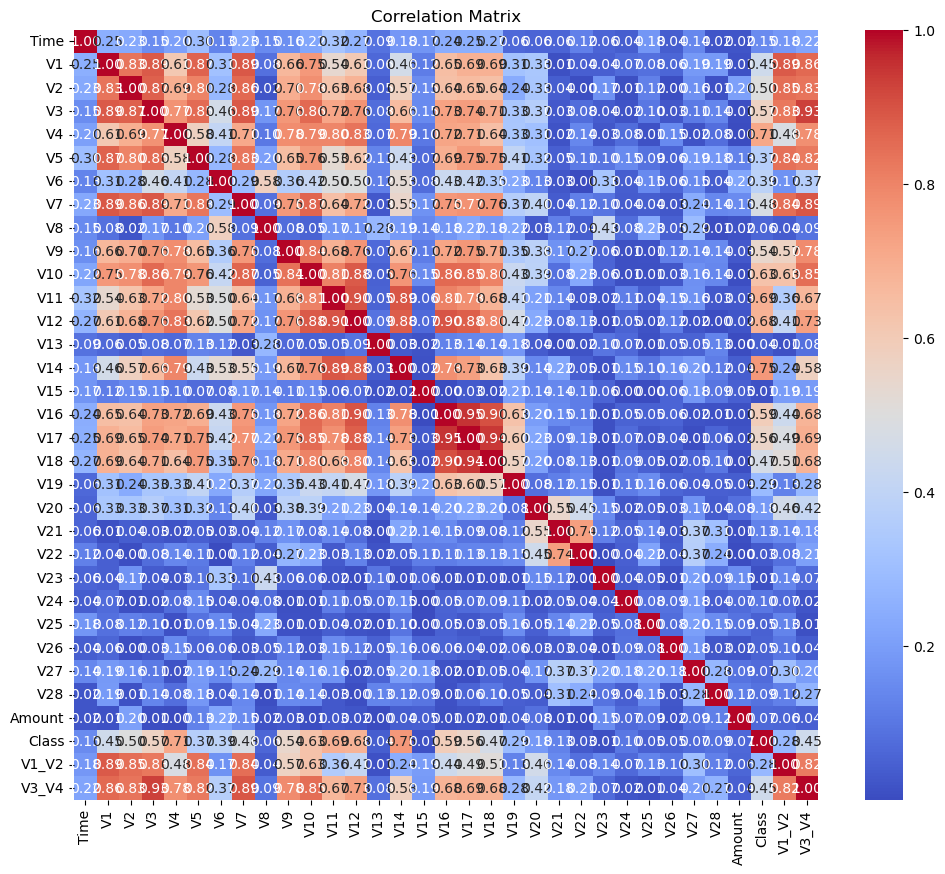

In [20]:
# Visualizing the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [21]:
# Splitting the data into features and target
X = new_df.drop(columns='Class', axis=1)
y = new_df['Class']

In [22]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,V1_V2,V3_V4
93052,64232.0,-2.281747,1.762547,1.002281,1.346975,1.171247,-0.014684,-2.245163,-3.640916,-0.234197,...,-1.557153,-1.354478,0.171412,-0.658136,-0.307414,0.122395,0.154678,8.99,-4.021686,1.350048
174325,121864.0,2.003337,0.117533,-1.604081,0.348192,0.412087,-0.650453,0.126543,-0.127905,0.155737,...,-0.767001,0.338135,0.681931,-0.301768,0.140265,-0.065028,-0.036379,9.99,0.235459,-0.558528
111358,72201.0,-1.018243,-1.348220,0.820463,-2.455206,0.087339,-0.493934,0.487459,-0.179301,-2.696183,...,-0.737943,0.542724,-0.396358,-0.231227,-0.638706,0.112848,-0.018127,190.24,1.372815,-2.014406
34176,37546.0,-1.006521,-0.398775,2.016261,-2.059985,-0.333697,0.190276,0.657847,0.052557,1.195073,...,0.613857,-0.217488,-0.510034,0.730196,-0.615608,-0.121142,-0.154538,151.47,0.401375,-4.153467
243088,151786.0,-0.027795,-0.470520,0.725969,-2.748069,-0.249094,-0.373433,-0.184319,-0.060797,-2.422552,...,0.375763,-0.148833,-0.465258,-0.433957,-0.229383,0.180951,0.163708,6.00,0.013078,-1.995014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,-2.170127,-7.903882
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1.777488,-7.065245
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,-0.761584,-1.036694
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,-1.824282,-9.811809


In [23]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# Handling Class Imbalance using SMOTE
smote = SMOTE(random_state=2)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [25]:
# Splitting the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=2)

In [26]:
# Combining features and target for saving
train_data = pd.DataFrame(X_train)
train_data['Class'] = y_train
test_data = pd.DataFrame(X_test)
test_data['Class'] = y_test

In [27]:
# Saving to CSV
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

In [28]:
# Initializing the S3 client
s3 = boto3.client('s3')

In [29]:
# Uploading the files to S3
s3.upload_file('train_data.csv', bucket, 'datasets/train_data.csv')
s3.upload_file('test_data.csv', bucket, 'datasets/test_data.csv')
print(f'Train and test data uploaded to s3://{bucket}/datasets')

Train and test data uploaded to s3://saobucketfraudetector/datasets


In [30]:
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.session import Session
from sagemaker.sklearn.estimator import SKLearn
import os

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/20/25 05:39:50] INFO     Found credentials from IAM Role:                                   ]8;id=557259;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=148414;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [31]:
import time

# Adding an event time feature to the dataset
new_df['event_time'] = pd.to_datetime('now').strftime('%Y-%m-%dT%H:%M:%SZ')

/tmp/ipykernel_8645/2783839291.py:4: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  new_df['event_time'] = pd.to_datetime('now').strftime('%Y-%m-%dT%H:%M:%SZ')


In [32]:
new_df


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,V1_V2,V3_V4,event_time
93052,64232.0,-2.281747,1.762547,1.002281,1.346975,1.171247,-0.014684,-2.245163,-3.640916,-0.234197,...,0.171412,-0.658136,-0.307414,0.122395,0.154678,8.99,0,-4.021686,1.350048,2025-03-20T05:39:54Z
174325,121864.0,2.003337,0.117533,-1.604081,0.348192,0.412087,-0.650453,0.126543,-0.127905,0.155737,...,0.681931,-0.301768,0.140265,-0.065028,-0.036379,9.99,0,0.235459,-0.558528,2025-03-20T05:39:54Z
111358,72201.0,-1.018243,-1.348220,0.820463,-2.455206,0.087339,-0.493934,0.487459,-0.179301,-2.696183,...,-0.396358,-0.231227,-0.638706,0.112848,-0.018127,190.24,0,1.372815,-2.014406,2025-03-20T05:39:54Z
34176,37546.0,-1.006521,-0.398775,2.016261,-2.059985,-0.333697,0.190276,0.657847,0.052557,1.195073,...,-0.510034,0.730196,-0.615608,-0.121142,-0.154538,151.47,0,0.401375,-4.153467,2025-03-20T05:39:54Z
243088,151786.0,-0.027795,-0.470520,0.725969,-2.748069,-0.249094,-0.373433,-0.184319,-0.060797,-2.422552,...,-0.465258,-0.433957,-0.229383,0.180951,0.163708,6.00,0,0.013078,-1.995014,2025-03-20T05:39:54Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1,-2.170127,-7.903882,2025-03-20T05:39:54Z
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1,1.777488,-7.065245,2025-03-20T05:39:54Z
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1,-0.761584,-1.036694,2025-03-20T05:39:54Z
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1,-1.824282,-9.811809,2025-03-20T05:39:54Z


In [33]:
import uuid

# Add unique TransactionID column
new_df["record_id"] = [str(uuid.uuid4()) for _ in range(len(new_df))]
new_df["record_id"] = new_df["record_id"].astype(str)

In [34]:
new_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,V1_V2,V3_V4,event_time,record_id
93052,64232.0,-2.281747,1.762547,1.002281,1.346975,1.171247,-0.014684,-2.245163,-3.640916,-0.234197,...,-0.658136,-0.307414,0.122395,0.154678,8.99,0,-4.021686,1.350048,2025-03-20T05:39:54Z,a42bd7fc-4454-4734-8044-63cd3bcb55ec
174325,121864.0,2.003337,0.117533,-1.604081,0.348192,0.412087,-0.650453,0.126543,-0.127905,0.155737,...,-0.301768,0.140265,-0.065028,-0.036379,9.99,0,0.235459,-0.558528,2025-03-20T05:39:54Z,01d45e06-fd1a-442c-82e5-42f351fc3915
111358,72201.0,-1.018243,-1.348220,0.820463,-2.455206,0.087339,-0.493934,0.487459,-0.179301,-2.696183,...,-0.231227,-0.638706,0.112848,-0.018127,190.24,0,1.372815,-2.014406,2025-03-20T05:39:54Z,093d5158-0b42-491e-b42f-e8a03878c0f0
34176,37546.0,-1.006521,-0.398775,2.016261,-2.059985,-0.333697,0.190276,0.657847,0.052557,1.195073,...,0.730196,-0.615608,-0.121142,-0.154538,151.47,0,0.401375,-4.153467,2025-03-20T05:39:54Z,46133d81-b395-45b9-8dfd-28aeb9de20a4
243088,151786.0,-0.027795,-0.470520,0.725969,-2.748069,-0.249094,-0.373433,-0.184319,-0.060797,-2.422552,...,-0.433957,-0.229383,0.180951,0.163708,6.00,0,0.013078,-1.995014,2025-03-20T05:39:54Z,fd3156c6-ce93-4a40-bdc7-ceed07810d0d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.537503,0.788395,0.292680,0.147968,390.00,1,-2.170127,-7.903882,2025-03-20T05:39:54Z,52f44b84-c34c-4585-a872-a17f4740efc6
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.521875,0.739467,0.389152,0.186637,0.76,1,1.777488,-7.065245,2025-03-20T05:39:54Z,13c7efd9-ebb3-4e9b-8a53-ef7ce8d5edfd
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,-0.739695,0.471111,0.385107,0.194361,77.89,1,-0.761584,-1.036694,2025-03-20T05:39:54Z,e235761a-1e10-4f25-8a71-e89a7ba9c597
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,-0.328168,0.606116,0.884876,-0.253700,245.00,1,-1.824282,-9.811809,2025-03-20T05:39:54Z,8b0ec19a-f853-485a-8d91-92c9515feeae


In [35]:
import logging
from sagemaker.feature_store.feature_definition import FeatureDefinition,FeatureTypeEnum
from sagemaker.feature_store.feature_group import FeatureGroup, IngestionError  # Import IngestionError
import sagemaker

# Initialize SageMaker session
sagemaker_session = sagemaker.Session()

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# Define feature group
feature_group_name = 'credit-card-fraud-feature-groupV1'
feature_group = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=sagemaker_session,
    feature_definitions=[
        FeatureDefinition(feature_name='V1_V2', feature_type=FeatureTypeEnum.FRACTIONAL),
        FeatureDefinition(feature_name='V3_V4', feature_type=FeatureTypeEnum.FRACTIONAL),
        FeatureDefinition(feature_name='event_time', feature_type=FeatureTypeEnum.STRING),
        FeatureDefinition(feature_name='record_id', feature_type=FeatureTypeEnum.STRING),
        # Add other feature definitions here
    ]
)


# Create feature group
feature_group.create(
    s3_uri=f's3://saobucketfraudetector/feature-store',
    record_identifier_name='record_id',
    event_time_feature_name='event_time',
    role_arn='arn:aws:iam::361769587425:role/service-role/AmazonSageMaker-ExecutionRole-20250204T104128',
    enable_online_store=True
)



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:30                                                                                   │
│                                                                                                  │
│   27                                                                                             │
│   28                                                                                             │
│   29 # Create feature group                                                                      │
│ ❱ 30 feature_group.create(                                                                       │
│   31 │   s3_uri=f's3://saobucketfraudetector/feature-store',                                     │
│   32 │   record_identifier_name='record_id',                                                     │
│   33 │   event_time_feature_name='event_time',                                                   │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/feature_store/featu │
│ re_group.py:789 in create                                                                        │
│                                                                                                  │
│    786 │   │   │   │   {"offline_store_config": offline_store_config.to_dict()}                  │
│    787 │   │   │   )                                                                             │
│    788 │   │                                                                                     │
│ ❱  789 │   │   return self.sagemaker_session.create_feature_group(**create_feature_store_args)   │
│    790 │                                                                                         │
│    791 │   def delete(self):                                                                     │
│    792 │   │   """Delete a FeatureGroup."""                                                      │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py:6300 in  │
│ create_feature_group                                                                             │
│                                                                                                  │
│   6297 │   │   │   Description=description,                                                      │
│   6298 │   │   │   Tags=tags,                                                                    │
│   6299 │   │   )                                                                                 │
│ ❱ 6300 │   │   return self.sagemaker_client.create_feature_group(**kwargs)                       │
│   6301 │                                                                                         │
│   6302 │   def describe_feature_group(                                                           │
│   6303 │   │   self,                                                                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/client.py:570 in     │
│ _api_call                                                                                        │
│                                                                                                  │
│    567 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    568 │   │   │   │   )                                                                         │
│    569 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  570 │   │   │   return self._make_api_call(operation_nam

In [36]:
import boto3

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Describe the Feature Group
try:
    response = sagemaker_client.describe_feature_group(FeatureGroupName='credit-card-fraud-feature-groupV1')
    print("Feature Group Details:")
    print(response)
except sagemaker_client.exceptions.ResourceNotFound:
    print("Feature Group not found. Please check the name and ensure it was created successfully.")

Feature Group Details:
{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:361769587425:feature-group/credit-card-fraud-feature-groupV1', 'FeatureGroupName': 'credit-card-fraud-feature-groupV1', 'RecordIdentifierFeatureName': 'record_id', 'EventTimeFeatureName': 'event_time', 'FeatureDefinitions': [{'FeatureName': 'V1_V2', 'FeatureType': 'Fractional'}, {'FeatureName': 'V3_V4', 'FeatureType': 'Fractional'}, {'FeatureName': 'event_time', 'FeatureType': 'String'}, {'FeatureName': 'record_id', 'FeatureType': 'String'}], 'CreationTime': datetime.datetime(2025, 3, 7, 10, 35, 22, 914000, tzinfo=tzlocal()), 'OnlineStoreConfig': {'EnableOnlineStore': True}, 'OfflineStoreConfig': {'S3StorageConfig': {'S3Uri': 's3://saobucketfraudetector/feature-store', 'ResolvedOutputS3Uri': 's3://saobucketfraudetector/feature-store/361769587425/sagemaker/us-east-1/offline-store/credit-card-fraud-feature-groupV1-1741343722/data'}, 'DisableGlueTableCreation': False, 'DataCatalogConfig': {'TableName': 'credit_card_fr

In [37]:
# Check data types
print(new_df.dtypes)

Time          float64
V1            float64
V2            float64
V3            float64
V4            float64
V5            float64
V6            float64
V7            float64
V8            float64
V9            float64
V10           float64
V11           float64
V12           float64
V13           float64
V14           float64
V15           float64
V16           float64
V18           float64
V19           float64
V20           float64
V21           float64
V22           float64
V23           float64
V24           float64
V25           float64
V26           float64
V27           float64
V28           float64
Amount        float64
Class           int64
V1_V2         float64
V3_V4         float64
event_time     object
record_id      object
dtype: object


In [38]:
# Inspect sample data
sample_df = new_df[['V1_V2', 'V3_V4', 'record_id', 'event_time']].head(10)
print("Sample Data:")
print(sample_df)

Sample Data:
           V1_V2     V3_V4                             record_id  \
93052  -4.021686  1.350048  a42bd7fc-4454-4734-8044-63cd3bcb55ec   
174325  0.235459 -0.558528  01d45e06-fd1a-442c-82e5-42f351fc3915   
111358  1.372815 -2.014406  093d5158-0b42-491e-b42f-e8a03878c0f0   
34176   0.401375 -4.153467  46133d81-b395-45b9-8dfd-28aeb9de20a4   
243088  0.013078 -1.995014  fd3156c6-ce93-4a40-bdc7-ceed07810d0d   
64455   0.103271  2.038960  662775b1-7585-4bd5-8728-a2a8af59f3b8   
11036   0.250787  0.308217  027a6ef0-02e2-4a7f-8359-a3541012ac55   
196111 -0.668040 -0.117060  8b5e8a09-8474-45c2-b080-4e0754ca00ba   
166883  0.221447 -0.689784  28a89e15-e130-4d95-a655-85615d6e8d0f   
207821 -0.632802  0.163686  6e849aca-9632-433d-9f39-d02b42619f08   

                  event_time  
93052   2025-03-20T05:39:54Z  
174325  2025-03-20T05:39:54Z  
111358  2025-03-20T05:39:54Z  
34176   2025-03-20T05:39:54Z  
243088  2025-03-20T05:39:54Z  
64455   2025-03-20T05:39:54Z  
11036   2025-03-20T05

In [39]:
# Check for null values
print("Null Values in  Dataset:")
print(new_df.isnull().sum())

Null Values in  Dataset:
Time          0
V1            0
V2            0
V3            0
V4            0
V5            0
V6            0
V7            0
V8            0
V9            0
V10           0
V11           0
V12           0
V13           0
V14           0
V15           0
V16           0
V18           0
V19           0
V20           0
V21           0
V22           0
V23           0
V24           0
V25           0
V26           0
V27           0
V28           0
Amount        0
Class         0
V1_V2         0
V3_V4         0
event_time    0
record_id     0
dtype: int64


In [40]:
# Validate data types
print("Data Types in new_df[['V1_V2', 'V3_V4', 'record_id', 'event_time']]:")
print(new_df[['V1_V2', 'V3_V4', 'record_id', 'event_time']].dtypes)

Data Types in new_df[['V1_V2', 'V3_V4', 'record_id', 'event_time']]:
V1_V2         float64
V3_V4         float64
record_id      object
event_time     object
dtype: object


In [41]:
# Check for special characters in 'record_id' and 'event_time'
print("Special Characters in 'record_id':")
print(new_df['record_id'].str.contains(r'[^\w\s]').sum())
print("Special Characters in 'event_time':")
print(new_df['event_time'].str.contains(r'[^\w\s]').sum())


Special Characters in 'record_id':
984
Special Characters in 'event_time':
984


In [42]:
import re

# Function to remove special characters
def clean_column(column):
    return column.apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Clean 'record_id' and 'event_time' columns
new_df['record_id'] = clean_column(new_df['record_id'])
new_df['event_time'] = clean_column(new_df['event_time'])

In [43]:
# Inspect cleaned sample data
sample_df = new_df[['V1_V2', 'V3_V4', 'record_id', 'event_time']]
print("Cleaned Sample Data:")
print(new_df[['V1_V2', 'V3_V4', 'record_id', 'event_time']])

Cleaned Sample Data:
           V1_V2     V3_V4                         record_id        event_time
93052  -4.021686  1.350048  a42bd7fc44544734804463cd3bcb55ec  20250320T053954Z
174325  0.235459 -0.558528  01d45e06fd1a442c82e542f351fc3915  20250320T053954Z
111358  1.372815 -2.014406  093d51580b42491eb42fe8a03878c0f0  20250320T053954Z
34176   0.401375 -4.153467  46133d81b39545b98dfd28aeb9de20a4  20250320T053954Z
243088  0.013078 -1.995014  fd3156c6ce934a40bdc7ceed07810d0d  20250320T053954Z
...          ...       ...                               ...               ...
279863 -2.170127 -7.903882  52f44b84c34c4585a872a17f4740efc6  20250320T053954Z
280143  1.777488 -7.065245  13c7efd9ebb34e9b8a53ef7ce8d5edfd  20250320T053954Z
280149 -0.761584 -1.036694  e235761a1e104f258a71e89a7ba9c597  20250320T053954Z
281144 -1.824282 -9.811809  8b0ec19af853485a8d9192c9515feeae  20250320T053954Z
281674  0.315680 -1.055775  5651d686b8734c7bb72e405c5ede704c  20250320T053954Z

[984 rows x 4 columns]


In [44]:
print("Special Characters in 'record_id':")
print(new_df['record_id'].str.contains(r'[^\w\s]').sum())
print("Special Characters in 'event_time':")
print(new_df['event_time'].str.contains(r'[^\w\s]').sum())

Special Characters in 'record_id':
0
Special Characters in 'event_time':
0


In [45]:
# Check DataFrame size
print("DataFrame Size:")
print(new_df.shape)

DataFrame Size:
(984, 34)


In [46]:
# Validate feature definitions
print("Feature Definitions:")
for feature in feature_group.feature_definitions:
    print(f"{feature.feature_name}: {feature.feature_type}")


Feature Definitions:
V1_V2: FeatureTypeEnum.FRACTIONAL
V3_V4: FeatureTypeEnum.FRACTIONAL
event_time: FeatureTypeEnum.STRING
record_id: FeatureTypeEnum.STRING


In [47]:
import pandas as pd
import time
from tqdm import tqdm
import boto3

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')
featurestore_runtime = boto3.client('sagemaker-featurestore-runtime')

# Wait for feature group to be ready
while feature_group.describe()["FeatureGroupStatus"] != "Created":
    print("Waiting for Feature Group to be created...")
    time.sleep(10)

# Convert event_time to ISO-8601 format
new_df['event_time'] = pd.to_datetime(new_df['event_time']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Convert DataFrame to records
def format_record(row):
    return [
        {"FeatureName": "V1_V2", "ValueAsString": str(row["V1_V2"])},
        {"FeatureName": "V3_V4", "ValueAsString": str(row["V3_V4"])},
        {"FeatureName": "record_id", "ValueAsString": row["record_id"]},
        {"FeatureName": "event_time", "ValueAsString": row["event_time"]}
    ]

records = [format_record(row) for index, row in new_df[['V1_V2', 'V3_V4', 'record_id', 'event_time']].iterrows()]

# Ingest in batches of 500
batch_size = 500
for i in tqdm(range(0, len(records), batch_size)):
    batch = records[i : i + batch_size]
    try:
        for record in batch:
            featurestore_runtime.put_record(FeatureGroupName=feature_group_name, Record=record)
    except Exception as e:
        print(f"Batch {i // batch_size} failed: {e}")


100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


In [48]:
import boto3

# Initialize SageMaker Feature Store runtime client
featurestore_runtime = boto3.client('sagemaker-featurestore-runtime')

# Define the feature group name and record identifier
feature_group_name = 'credit-card-fraud-feature-groupV1'
record_id = 'record_id'  # Replace with an actual record ID from your dataset

# Retrieve the record from the Feature Store
response = featurestore_runtime.get_record(
    FeatureGroupName=feature_group_name,
    RecordIdentifierValueAsString=record_id
)

# Print the retrieved record
print("Retrieved Record:")
print(response)

Retrieved Record:
{'ResponseMetadata': {'RequestId': '7416f81b-56a8-4a85-9002-2aab8a9296ab', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7416f81b-56a8-4a85-9002-2aab8a9296ab', 'content-type': 'application/json', 'content-length': '32', 'date': 'Thu, 20 Mar 2025 05:40:43 GMT'}, 'RetryAttempts': 0}}


In [55]:
#train.py
script_content = """
import argparse
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import joblib
import os
import numpy as np
import mlflow
import mlflow.sklearn

def model_fn(model_dir):
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    return model

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--output-data-dir', type=str, default='/opt/ml/output/data')
    parser.add_argument('--model-dir', type=str, default='/opt/ml/model')
    parser.add_argument('--train', type=str, default='/opt/ml/input/data/train')
    parser.add_argument('--test', type=str, default='/opt/ml/input/data/test')
    
    args = parser.parse_args()
    
    try:
        # Increase timeout for MLflow HTTP requests
        os.environ['MLFLOW_HTTP_REQUEST_TIMEOUT'] = '300'  # Increase timeout to 300 seconds
        mlflow.set_tracking_uri("http://52.207.216.244:5000")
        
        # Start an MLflow run
        mlflow.start_run()

        # Load the train and test datasets from S3
        train_data = pd.read_csv(os.path.join(args.train, "train_data.csv"))
        test_data = pd.read_csv(os.path.join(args.test, "test_data.csv"))

        # Handle NaN and infinite values
        train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        train_data.dropna(inplace=True)
        test_data.dropna(inplace=True)

        # Split features and target
        X_train = train_data.drop(columns='Class')
        y_train = train_data['Class']
        X_test = test_data.drop(columns='Class')
        y_test = test_data['Class']

        # Train the model
        model = LogisticRegression()
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        print(f"F1 Score: {f1}")

        # Log the model with MLflow
        mlflow.sklearn.log_model(model, "model")
        mlflow.log_metric("f1_score", f1)

        # Save the model regardless of the F1 score
        joblib.dump(model, os.path.join(args.model_dir, "model.joblib"))

        # End the MLflow run
        mlflow.end_run()
        
    except Exception as e:
        print(f"Error during training: {e}")
        raise

"""

with open('train.py', 'w') as file:
    file.write(script_content)

In [56]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn



In [57]:

# sagemaker_session = sagemaker.Session()
# role ='arn:aws:iam::361769587425:role/service-role/AmazonSageMaker-ExecutionRole-20250204T104128'
# estimator = SKLearn(
#     entry_point="train.py",
#     role=role,
#     instance_count=1,
#     instance_type="ml.m5.large",
#     framework_version="0.23-1",
#     output_path=f"s3://{bucket}/output",
#     sagemaker_session=sagemaker_session
# )
 
# # Fit the estimator
# estimator.fit({
#     "train": f"s3://{bucket}/datasets/train_data.csv",
#     "test": f"s3://{bucket}/datasets/test_data.csv"
# })




# Create an estimator
sagemaker_session = sagemaker.Session()
role = 'arn:aws:iam::361769587425:role/service-role/AmazonSageMaker-ExecutionRole-20250204T104128'
estimator = SKLearn(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="0.23-1",
    output_path=f"s3://saobucketfraudetector/modelsV2",
    sagemaker_session=sagemaker_session,
    dependencies=['requirements.txt']
)


# Fit the estimator
estimator.fit({
    "train": f"s3://saobucketfraudetector/datasets/train_data.csv",
    "test": f"s3://saobucketfraudetector/datasets/test_data.csv"
})

[03/20/25 10:49:03] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=652104;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=226234;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=701472;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=671991;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-scikit-learn-2025-03-20-10-49-03-518                                        

2025-03-20 10:49:05 Starting - Starting the training job...
..25-03-20 10:49:19 Starting - Preparing the instances for training.
..25-03-20 10:49:41 Downloading - Downloading input data.
..25-03-20 10:50:11 Downloading - Downloading the training image.
2025-03-20 10:51:07 Training - Training image download completed. Training in progress.
2025-03-20 10:51:07 Uploading - Uploading generated training model2025-03-20 10:50:51,031 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-03-20 10:50:51,035 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-03-20 10:50:51,077 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-03-20 10:50:51,266 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [58]:
# Print the S3 path where the model artifacts are stored
print(f"Model artifacts are stored at: {estimator.model_data}")


Model artifacts are stored at: s3://saobucketfraudetector/modelsV2/sagemaker-scikit-learn-2025-03-20-10-49-03-518/output/model.tar.gz


In [59]:
import sagemaker
from sagemaker import image_uris

# Specify the framework, version, and region
framework = 'sklearn'
version = '0.23-1'
region = 'us-east-1'

# Retrieve the image URI
image_uri = image_uris.retrieve(framework, region, version)
print(f"Image URI: {image_uri}")

[03/20/25 10:59:35] INFO     Defaulting to only available Python version: py3                     ]8;id=427794;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=994144;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#610\610]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=259013;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=715589;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#534\534]8;;\

Image URI: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3


In [60]:
from sagemaker.model import Model

sagemaker_session = sagemaker.Session()
role = 'arn:aws:iam::361769587425:role/service-role/AmazonSageMaker-ExecutionRole-20250204T104128'
# Create the model
image_uri = '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3'

model = Model(
    model_data=estimator.model_data,
    role=role,
    entry_point="train.py",
    image_uri=image_uri,
    sagemaker_session=sagemaker_session
)

In [61]:
# Print the S3 path where the model artifacts are stored
print(f"Model artifacts are stored at: {estimator.model_data}")

Model artifacts are stored at: s3://saobucketfraudetector/modelsV2/sagemaker-scikit-learn-2025-03-20-10-49-03-518/output/model.tar.gz


In [ ]:
# Deploy the model for online inference
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name ="fraud-detection-endpointV2"
    
)

[03/20/25 11:00:52] INFO     Creating model with name:                                              ]8;id=285638;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=73600;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\
                             sagemaker-scikit-learn-2025-03-20-11-00-52-598                                        

[03/20/25 11:00:53] INFO     Creating endpoint-config with name fraud-detection-endpointV2          ]8;id=503693;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=810569;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name fraud-detection-endpointV2                 ]8;id=491124;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=861550;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-----------------------------------------------*

[03/20/25 11:26:59] ERROR    Please check the troubleshooting guide for common errors:              ]8;id=498361;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=887412;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4782\4782]8;;\
                             https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-t                
                             roubleshooting.html#sagemaker-python-sdk-troubleshooting-create-endpoi                
                             nt                                                                                    

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Deploy the model for online inference                                                      │
│ ❱ 2 predictor = model.deploy(                                                                    │
│   3 │   initial_instance_count=1,                                                                │
│   4 │   instance_type="ml.m5.large",                                                             │
│   5 │   endpoint_name ="fraud-detection-endpointV2"                                              │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/model.py:1786 in    │
│ deploy                                                                                           │
│                                                                                                  │
│   1783 │   │   │   if is_explainer_enabled:                                                      │
│   1784 │   │   │   │   explainer_config_dict = explainer_config._to_request_dict()               │
│   1785 │   │   │                                                                                 │
│ ❱ 1786 │   │   │   self.sagemaker_session.endpoint_from_production_variants(                     │
│   1787 │   │   │   │   name=self.endpoint_name,                                                  │
│   1788 │   │   │   │   production_variants=[production_variant],                                 │
│   1789 │   │   │   │   tags=tags,                                                                │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py:5940 in  │
│ endpoint_from_production_variants                                                                │
│                                                                                                  │
│   5937 │   │   logger.info("Creating endpoint-config with name %s", name)                        │
│   5938 │   │   self.sagemaker_client.create_endpoint_config(**config_options)                    │
│   5939 │   │                                                                                     │
│ ❱ 5940 │   │   return self.create_endpoint(                                                      │
│   5941 │   │   │   endpoint_name=name,                                                           │
│   5942 │   │   │   config_name=name,                                                             │
│   5943 │   │   │   tags=endpoint_tags,                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py:4785 in  │
│ create_endpoint                                                                                  │
│                                                                                                  │
│   4782 │   │   │   logger.error(                                                                 │
│   4783 │   │   │   │   "Please check the troubleshooting guide for common errors: %s", troubles  │
│   4784 │   │   │   )                                                                             │
│ ❱ 4785 │   │   │   raise e                                                                       │
│   4786 │                                                                                         │
│   4787 │   def endpoint_in_service_or_not(self, endpoint_na

In [63]:
# import boto3
# import pandas as pd
# import io

# # Initialize the runtime client
# runtime_client = boto3.client("sagemaker-runtime")


# test_data = pd.read_csv("test_data.csv")
 
# # Convert dataframe to CSV string (without header and index)
# csv_data = test_data.to_csv(header=False, index=False).strip()

# # Get endpoint name (the one used for deployment)
# endpoint_name = "fraud-detection-endpoint3"

# # Invoke the endpoint for prediction
# response = runtime_client.invoke_endpoint(
#     EndpointName=endpoint_name,
#     ContentType="text/csv",  # Specify the CSV format
#     Body=csv_data
# )

# # Read and print the response
# response_body = response["Body"].read().decode("utf-8")
# print("Prediction response:", response_body)
import boto3
import pandas as pd
import io

# Initialize the runtime client
runtime_client = boto3.client("sagemaker-runtime")

# Sample input data (you can replace this with your actual input data)
# Load test data (Ensure it has the same feature columns used for training)
test_data = pd.read_csv("test_data.csv")

# Convert dataframe to CSV string (without header and index)
csv_data = test_data.to_csv(header=False, index=False).strip()

# Get endpoint name (the one used for deployment)
endpoint_name = "fraud-detection-endpointV2"

try:
    # Invoke the endpoint for prediction
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="text/csv",  # Specify the CSV format
        Body=csv_data
    )

    # Read and print the response
    response_body = response["Body"].read().decode("utf-8")
    print("Prediction response:", response_body)

except Exception as e:
    print(f"Error invoking endpoint: {e}")



Error invoking endpoint: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/fraud-detection-endpoint3 in account 361769587425 for more information.


In [56]:
# !python train.py

Error during training: [Errno 2] No such file or directory: '/opt/ml/input/data/train/train_data.csv'
Traceback (most recent call last):
  File "/home/ec2-user/SageMaker/train.py", line 29, in <module>
    train_data = pd.read_csv(os.path.join(args.train, "train_data.csv"))
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 950, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 605, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3

In [66]:
bucket='saobucketfraudetector'